In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.sql.expression import text

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

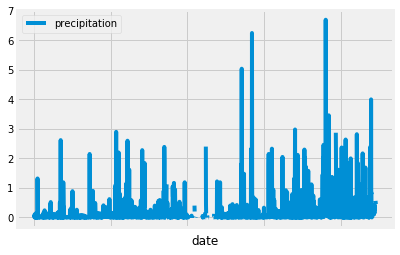

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date = (session
                .query(func.max(Measurement.date))
                .first()
               )
dt_latest_date = dt.datetime.strptime(latest_date[0],'%Y-%m-%d')
twelve_months_ago = dt.date(dt_latest_date.year - 1, dt_latest_date.month, dt_latest_date.day)

# Perform a query to retrieve the data and precipitation scores
precipitation = (session
                 .query(Measurement.date, Measurement.prcp)
                 .filter(Measurement.date >= func.strftime('%Y-%m-%d', twelve_months_ago))
                ).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation, columns=["date","precipitation"]).set_index("date")

# Sort the dataframe by date
precipitation_df.sort_values(by=["date"])

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot.line()


![precipitation](Images/precipitation.png)

In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [11]:
# Design a query to show how many stations are available in this dataset?
station_count = (session
                 .query(Measurement.station.distinct())
                 .count()
                )
print(station_count)

9


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = (session
             .query(Measurement.station,func.count(Measurement.station).label('count'))
             .order_by(func.count(Measurement.station).desc())
             .group_by(Measurement.station)
             .all()
            )
for station in stations:
    print(f"Station: {station.station}, Count: {station.count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station_id = stations[0].station

temperatures = (session
               .query(func.max(Measurement.tobs).label('highest'),
                      func.min(Measurement.tobs).label('lowest'), 
                      func.avg(Measurement.tobs).label('average')
                     )
                .filter(Measurement.station == most_active_station_id)
                .first()
               )

print(f"Highest: {temperatures.highest}")
print(f"Lowest:  {temperatures.lowest}")
print(f"Average: {temperatures.average}")

Highest: 85.0
Lowest:  54.0
Average: 71.66378066378067


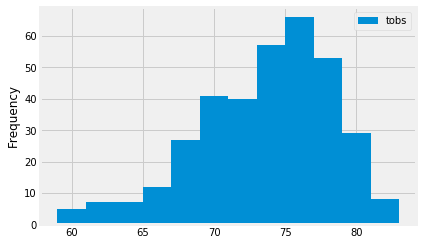

In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs = (session
            .query(Measurement.tobs)
            .filter(Measurement.station == most_active_station_id)
            .filter(Measurement.date >= func.strftime('%Y-%m-%d', twelve_months_ago))
            .all()
        )
temps = [t[0] for t in tobs]

plt.hist(temps,bins=12,label="tobs")
plt.ylabel("Frequency")
plt.legend()
plt.show()

![precipitation](Images/station-histogram.png)

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [67]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
date_check = True
while date_check:
    start_date = input("Enter the start date for your trip ('yyyy-mm-dd')")
    end_date = input("Enter the end date for your trip ('yyyy-mm-dd')")
    if(end_date >= start_date):
        date_check = False
    else:
        print("End date must come later than start date!")
        
dt_start_date = dt.datetime.strptime(start_date,'%Y-%m-%d')
dt_end_date = dt.datetime.strptime(end_date,'%Y-%m-%d')

dt_start_date = dt.date(dt_start_date.year - 1, dt_start_date.month, dt_start_date.day)
dt_end_date = dt.date(dt_end_date.year - 1, dt_end_date.month, dt_end_date.day)

# this gets values for all dates as a single block
normal_temps = calc_temps(dt_start_date, dt_end_date)

print(f"(min,max,avg) for {dt_start_date} through {dt_end_date} were: \n")
print(normal_temps)

Enter the start date for your trip ('yyyy-mm-dd')2017-03-03
Enter the end date for your trip ('yyyy-mm-dd')2017-03-09
(min,max,avg) for 2016-03-03 through 2016-03-09 were: 

[(62.0, 70.13333333333334, 78.0)]


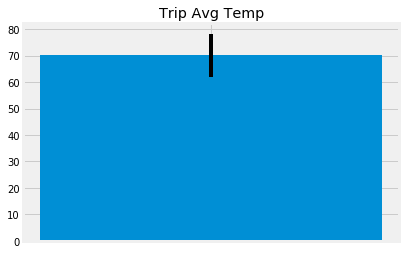

In [71]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

error = (normal_temps[0][1] - normal_temps[0][0], normal_temps[0][2] - normal_temps[0][1])
ave_temps = [t[0][1] for t in temps_list.values()]

plt.bar([''], [normal_temps[0][1]], yerr=[error])
plt.title("Trip Avg Temp")

plt.show()

In [89]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

total_rainfall = (session.query(Measurement.station, func.sum(Measurement.prcp), 
                                Station.name, Station.latitude, Station.longitude, Station.elevation)
#                   .from(Measurement)
                  .join(Station, Station.station == Measurement.station)
                  .filter(Measurement.date >= dt_start_date)
                  .filter(Measurement.date <= dt_end_date)
                  .group_by(Measurement.station)
                  .order_by(func.sum(Measurement.prcp).desc())
                  .all()
                 )
rainfall_df = pd.DataFrame(total_rainfall, 
                           columns=['station','total_precipitation', 'station_name','latitude','longitude','elevation']).set_index('station')
rainfall_df

,total_precipitation,station_name,latitude,longitude,elevation
station,,,,,
USC00519281,0.34,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
USC00519523,0.32,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
USC00514830,0.22,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
USC00516128,0.19,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
USC00519397,0.19,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
USC00513117,0.17,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
USC00517948,NaN,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [97]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [113]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
date_check = True
while date_check:
    start_date = input("Enter the start date for your trip ('yyyy-mm-dd')")
    end_date = input("Enter the end date for your trip ('yyyy-mm-dd')")
    if(end_date >= start_date):
        date_check = False
    else:
        print("End date must come later than start date!")
        
# Use the start and end date to create a range of dates
dt_start_date = dt.datetime.strptime(start_date,'%Y-%m-%d')
dt_end_date = dt.datetime.strptime(end_date,'%Y-%m-%d')

datelist = pd.date_range(start=dt_start_date,end=dt_end_date).tolist()

# numdays = dt_end_date - dt_start_date
# dateList = []
# for x in range (0, numdays):
#     dateList.append(a - datetime.timedelta(days = x))

# Stip off the year and save a list of %m-%d strings
new_date_list = [d.strftime('%m-%d') for d in datelist]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals_by_date = []
for trip_date in new_date_list:
    normals = daily_normals(trip_date)
    normals_by_date.append({
        'trip_date': str(trip_date),
        'min': normals[0][0],
        'ave': normals[0][1],
        'max': normals[0][2]
    })
    
normals_by_date

Enter the start date for your trip ('yyyy-mm-dd')2017-03-03
Enter the end date for your trip ('yyyy-mm-dd')2017-03-30


[{'trip_date': '03-03', 'min': 60.0, 'ave': 70.06896551724138, 'max': 78.0},
 {'trip_date': '03-04', 'min': 57.0, 'ave': 69.27272727272727, 'max': 77.0},
 {'trip_date': '03-05', 'min': 60.0, 'ave': 67.89090909090909, 'max': 76.0},
 {'trip_date': '03-06', 'min': 60.0, 'ave': 69.20338983050847, 'max': 76.0},
 {'trip_date': '03-07', 'min': 60.0, 'ave': 69.17241379310344, 'max': 78.0},
 {'trip_date': '03-08', 'min': 59.0, 'ave': 68.72413793103448, 'max': 78.0},
 {'trip_date': '03-09', 'min': 57.0, 'ave': 68.56140350877193, 'max': 75.0},
 {'trip_date': '03-10', 'min': 57.0, 'ave': 69.12280701754386, 'max': 75.0},
 {'trip_date': '03-11', 'min': 60.0, 'ave': 69.89285714285714, 'max': 82.0},
 {'trip_date': '03-12', 'min': 62.0, 'ave': 69.88888888888889, 'max': 80.0},
 {'trip_date': '03-13', 'min': 56.0, 'ave': 69.29629629629629, 'max': 77.0},
 {'trip_date': '03-14', 'min': 62.0, 'ave': 70.32758620689656, 'max': 77.0},
 {'trip_date': '03-15', 'min': 58.0, 'ave': 68.54716981132076, 'max': 76.0},

In [123]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normals_by_date).set_index('trip_date')
normal_df

,ave,max,min
trip_date,,,
03-03,70.068966,78.0,60.0
03-04,69.272727,77.0,57.0
03-05,67.890909,76.0,60.0
03-06,69.203390,76.0,60.0
03-07,69.172414,78.0,60.0
03-08,68.724138,78.0,59.0
03-09,68.561404,75.0,57.0
03-10,69.122807,75.0,57.0
03-11,69.892857,82.0,60.0


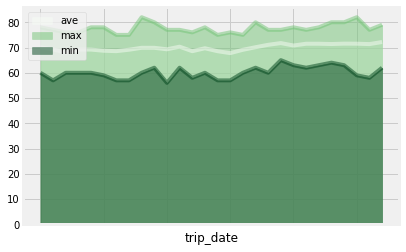

In [129]:
# Plot the daily normals as an area plot with `stacked=False`
# plt.stackplot(new_date_list,normal_df['ave'],normal_df['min'],normal_df['max'], labels=['average','minimum','maximum'],stacked=False)

normal_df.plot(kind='area', stacked=False, alpha=0.5, colormap='Greens', title="Temperature measur")
plt.legend(loc='upper left')
plt.show()